### Visualization of our EEG data 
A notebook with different methods to visualize our data and results of classification  
Author: Shateesh Bhugwansing

## NOTE (10/31): 
The sensor spacing is off. I need to figure out why.
things to try (for next week):
- plotting 2D position data

In [1]:
%run ../preprocessing/StimCodes.ipynb
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

In [18]:
# read in data 
epoch_path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(epoch_path, preload=True)

Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [19]:
path = '/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/Visualization/'
montage = mne.channels.read_montage(kind="ANT_DukeWaveGuard_128_electrode_montage_copy", ch_names=None, path=path, unit='mm', transform=False)

In [20]:
montage

<Montage | ANT_DukeWaveGuard_128_electrode_montage_copy - 127 channels: LE1, Nz, LE3 ...>

In [21]:
epoch.set_montage(montage)

The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-21-2b9523d69e31>:1: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Lm', 'Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage)


<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/mne/transforms.py:690: RuntimeWarning: invalid value encountered in true_divide
  out[:, 2] = np.arccos(cart[:, 2] / out[:, 0])


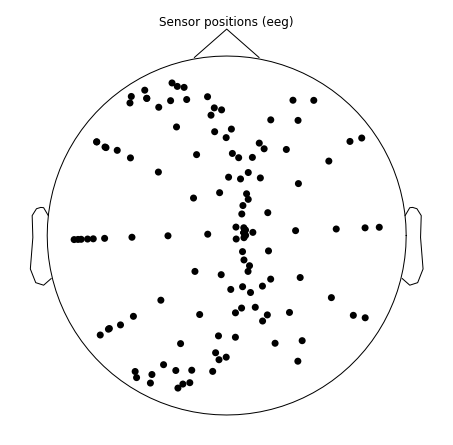

In [22]:
epoch.plot_sensors();

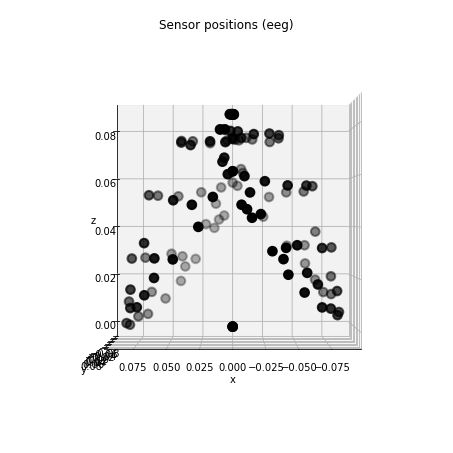

In [7]:
epoch.plot_sensors('3d');

In [23]:
## testing what the other montage file looks like (the example that Dave sent)

In [25]:
montage2 = mne.channels.read_montage(kind="eetrak124.elc", ch_names=None, path=path, unit='mm', transform=False)

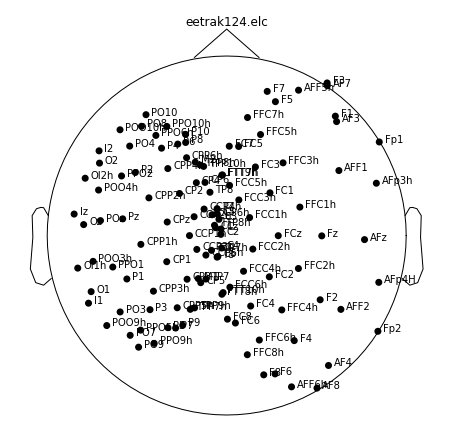

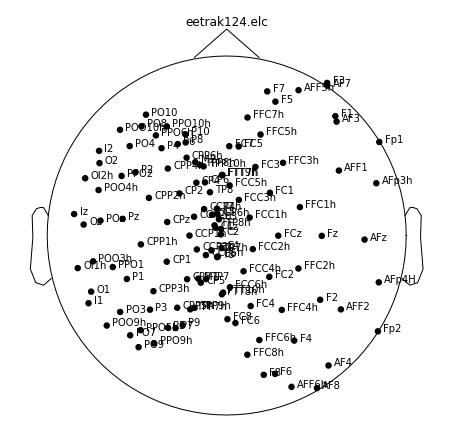

In [31]:
montage2.plot()

## Mapping coefficients to the channels
Map the coefficients of Logistic Regression to the channels of the ANT Waveguard Duke cap

In [ ]:
# %run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
# %run ../preprocessing/StimCodes.ipynb
# %run ../Classification/ConcatEpochTrails.ipynb
# %run ../PCA/Emmanuil-PCA.ipynb

from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

import time

In [ ]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [ ]:
## the following is from Emmanuil's Audio vs. Visual notebook

In [ ]:
# get indicies of trials of epoch object
trial_index_list = get_trial_index_list(epoch_object= epoch)

In [ ]:
# get new events for epoch object
new_event_list = convert_event_ids_to_stim_combinations(epoch_object=epoch,
                                                        trial_index_list = trial_index_list,
                                                        stim_combinations = stim_combinations)

In [ ]:
print(epoch.events.shape)
print(new_event_list.shape)

In [ ]:
# assign new events to current epoch object
epoch.events = new_event_list

# assign new event_ids to current epoch object (dictionary 
# found in ../Classification/ConcatEpochTrails.ipynb)
 
epoch.event_id = modality_lexicality_event_ids

In [ ]:
# classification time!

# Isolate audio vs visual codes
# audio codes are < 700, # visual codes are > 700 
# audio : 100 , visual : 101
for event in epoch.events:
    if event[-1] < 700:
        event[-1] = 100
    else:
        event[-1] = 101

In [ ]:
norm_pipe = make_pipeline(Vectorizer(), 
                          StandardScaler())
norm_pipe.fit(epoch.get_data())

In [ ]:
scaled_data = norm_pipe.transform(epoch.get_data())
scaled_data.shape

In [ ]:
# do PCA to reduce dimensions and data needed for classification.
# pca = UnsupervisedSpatialFilter(PCA(28), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
# pca_data = pca.fit_transform(epoch_data)

In [ ]:
# classification pipeline
start = time.time()
clf = make_pipeline(Vectorizer(),
                    StandardScaler(),
                    LogisticRegression(penalty='l1'))
end = time.time()
print("clf elapsed time: {0}".format(end - start))

start_master = time.time()
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

labels = epoch.events[:,-1]
preds = np.empty(len(epoch_data))
for train, test in cv.split(epoch_data, labels):
    start = time.time()
    clf.fit(epoch_data[train], labels[train])
    preds[test] = clf.predict(epoch_data[test])
    end = time.time()
    print("kfold elapsed time: {0}".format(end - start))
end = time.time()
print("classification elapsed time: {0}".format(end - start_master))


start = time.time()
target_names = ['Audio', 'Visual']
report = classification_report(labels, preds, target_names=target_names)
print(report)
end = time.time()
print("reporting elapsed time: {0}".format(end - start))

In [ ]:
## Emmanuil's classification code crashed. 
## Going to use what Tarekul did.

In [ ]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [ ]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim.events.shape

In [ ]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [ ]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [ ]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

In [ ]:
#New epoch with only visual stim code combinations
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [ ]:
from sklearn.cross_validation import train_test_split

#set features as epoch data
#set targets as event ids
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




In [ ]:
#new epoch with only events corresponding to 100 or 200(visual/audio stim codes)
binaryEpoch = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [ ]:
#pipeling for converting data from 3D to 2D using vectorizer and
#LogisticRegression for classification
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    (LogisticRegression(C=1)))

#Provides train/test indices to split data in train/test sets.
cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    #fit the model to training set
    clf.fit(X_train,y_train)
    
    #returns the mean accuracy on test data and labels
    score.append(clf.score(X_test,y_test))
    
    
    




In [ ]:
print("mean classification score", np.mean(score))

In [ ]:
from mne.decoding import get_coef
#get the coeficients after fitting clf to training sets
patterns2 = get_coef(clf,'coef_')
#print(patterns2)

#convert patterns2 to 129 x 180 array from 1 x 23220
#take each block of 180 coeficients and put them together 
#for each channel. We will have 129 channels rows with
#180 time columns
hold = []
for h in range(0,23219,180):
    temp = []
    for i in range(h,h+180):
        temp.append(patterns2[0][i])
    hold.append(temp)     
npHold = np.array(hold)
npHold.shape

In [ ]:
len(epoch.ch_names)

In [ ]:
npHold_avg = []

for i in range(len(npHold)):
    npHold_avg.append(np.mean(npHold[i]))

# npHold_avg = np.array(npHold_avg)
print (len(npHold_avg))


In [ ]:
channels = epoch.ch_names


In [ ]:
channels_and_coeff = dict(zip(channels, npHold_avg))
channels_and_coeff

In [ ]:
# by observation, the averaged coefficients seem to be biggest on the scale of 0.001 

coeff_of_interest = {k:v for (k,v) in channels_and_coeff.items() if abs(v) > 0.001 }

In [ ]:
coeff_of_interest

### Topography Map

In [ ]:
projs = mne.compute_proj_epochs(epoch)

In [ ]:
epoch_projs = epoch.add_proj(projs)

In [ ]:
type(epoch_projs)

In [ ]:
type(epoch)

In [ ]:
epoch_projs.plot_projs_topomap()

In [ ]:
epoch.plot_projs_topomap()

### topomap() is not working. Maybe I need to manaully create a layout